# Otter Image Demo (In-context Learning)

Here is an example of multi-modal ICL (in-context learning) with 🦦 Otter. We provide two demo images with corresponding instructions and answers, then we ask the model to generate an answer given our instruct. You may change your instruction and see how the model responds.

You can also try our [online demo](https://otter.cliangyu.com/) to see more in-context learning demonstrations.

必要なモジュールは各自インストール<br>
mlflow==2.6.0はバグがあるため使わないこと(https://github.com/mlflow/mlflow/issues/9331) (2023.08.23)

In [ ]:
# !pip install --upgrade mlflow==2.5.0 pydantic==2.1.1

In [6]:
import requests
import torch
import transformers
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.append("../..")
from otter.modeling_otter import OtterForConditionalGeneration

## 読み込み

In [7]:
# 15分
# model = OtterForConditionalGeneration.from_pretrained("luodian/OTTER-9B-LA-InContext", device_map="auto")
model = OtterForConditionalGeneration.from_pretrained("luodian/OTTER-Image-MPT7B", device_map="auto")
tokenizer = model.text_tokenizer
image_processor = transformers.CLIPImageProcessor()

Using pad_token, but it is not set yet.


You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.
The current model version is configured for Otter-Image with max_num_frames set to None.
Total Trainable param: 1.385404 B


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


### 特殊トークンの確認

In [8]:
model.text_tokenizer.all_special_tokens

['<|endoftext|>', '<PAD>', '<|endofchunk|>', '<image>', '<answer>']

## 画像とプロンプトの用意

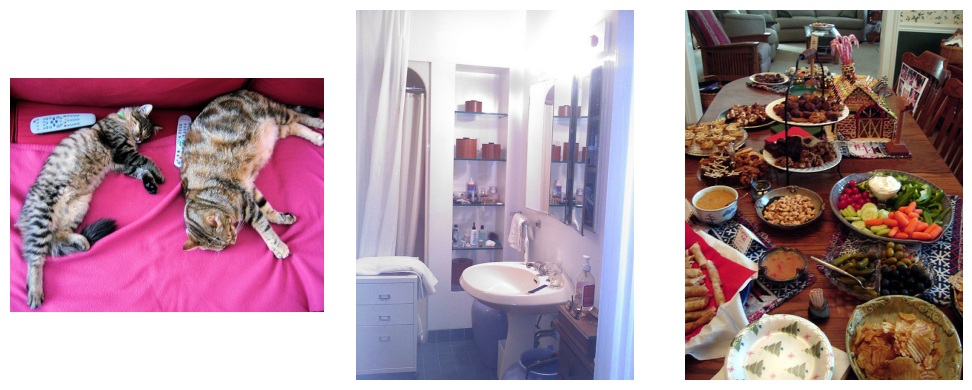

In [13]:
demo_image_one = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
demo_image_two = Image.open(requests.get("http://images.cocodataset.org/test-stuff2017/000000028137.jpg", stream=True).raw)
query_image = Image.open(requests.get("http://images.cocodataset.org/test-stuff2017/000000028352.jpg", stream=True).raw)

vision_x = image_processor.preprocess([demo_image_one, demo_image_two, query_image], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
model.text_tokenizer.padding_side = "left"
lang_x = model.text_tokenizer(
    [
        "<image>User: a photo of GPT:<answer> two cats sleeping.<|endofchunk|><image>User: a photo of GPT:<answer> a bathroom sink.<|endofchunk|><image>User: a photo of GPT:<answer>"
    ],
    return_tensors="pt",
)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(demo_image_one)
axes[0].axis('off')
axes[1].imshow(demo_image_two)
axes[1].axis('off')
axes[2].imshow(query_image)
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Get the data type from model's parameters
model_dtype = next(model.parameters()).dtype

# Convert tensors to the model's data type
vision_x = vision_x.to(dtype=model_dtype)
lang_x_input_ids = lang_x["input_ids"]
lang_x_attention_mask = lang_x["attention_mask"]

bad_words_id = model.text_tokenizer(["User:", "GPT1:", "GFT:", "GPT:"], add_special_tokens=False).input_ids
generated_text = model.generate(
    vision_x=vision_x.to(model.device),
    lang_x=lang_x_input_ids.to(model.device),
    attention_mask=lang_x_attention_mask.to(model.device),
    max_new_tokens=512,
    num_beams=3,
    no_repeat_ngram_size=3,
    bad_words_ids=bad_words_id,
)

parsed_output = (
    model.text_tokenizer.decode(generated_text[0]).split("<answer>")[-1].lstrip().rstrip().split("<|endofchunk|>")[0].lstrip().rstrip().lstrip('"').rstrip('"')
)

print("Generated text: ", parsed_output)

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  A table full of food.


## MVTecADで検証

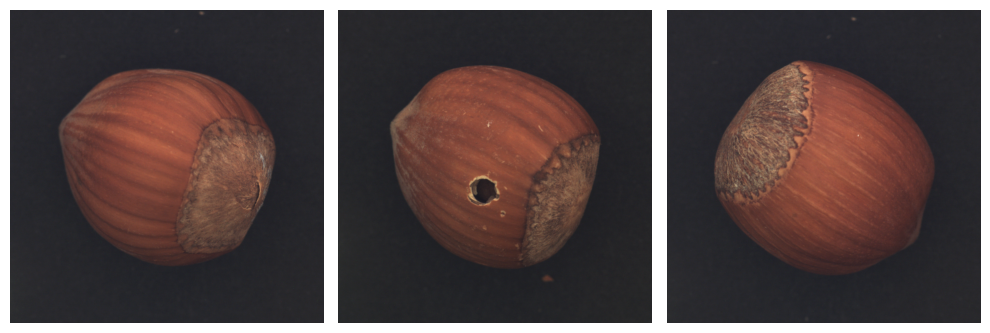

In [23]:
demo_image_one = Image.open("hazelnut/ok_001.png")
demo_image_two = Image.open("hazelnut/ng_003.png")
query_image = Image.open("hazelnut/ok_010.png")

vision_x = image_processor.preprocess([demo_image_one, demo_image_two, query_image], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
model.text_tokenizer.padding_side = "left"
lang_x = model.text_tokenizer(
    [
        "<image>User: Are there any defects in this image? GPT:<answer> No.<|endofchunk|><image>User: Are there any defects in this image? GPT:<answer> Yes.<|endofchunk|><image>User: Are there any defects in this image? GPT:<answer>"
    ],
    return_tensors="pt",
)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(demo_image_one)
axes[0].axis('off')
axes[1].imshow(demo_image_two)
axes[1].axis('off')
axes[2].imshow(query_image)
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Get the data type from model's parameters
model_dtype = next(model.parameters()).dtype

# Convert tensors to the model's data type
vision_x = vision_x.to(dtype=model_dtype)
lang_x_input_ids = lang_x["input_ids"]
lang_x_attention_mask = lang_x["attention_mask"]

bad_words_id = model.text_tokenizer(["User:", "GPT1:", "GFT:", "GPT:"], add_special_tokens=False).input_ids
generated_text = model.generate(
    vision_x=vision_x.to(model.device),
    lang_x=lang_x_input_ids.to(model.device),
    attention_mask=lang_x_attention_mask.to(model.device),
    max_new_tokens=512,
    num_beams=3,
    no_repeat_ngram_size=3,
    bad_words_ids=bad_words_id,
)

parsed_output = (
    model.text_tokenizer.decode(generated_text[0]).split("<answer>")[-1].lstrip().rstrip().split("<|endofchunk|>")[0].lstrip().rstrip().lstrip('"').rstrip('"')
)

print("Generated text: ", parsed_output)

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  There is a crack in the walnut.
